# 0.0. Entender Problema

-- Objetivo do Problema:
    -- 1.0. Previsao do primeiro destino que um novo usuário irá escolher.
    
    -- Porque?
        -- Qual tipo de modelo de negócio do Airbnb?
            -- Marketplace ( Conectar pessoas que oferecem acomodacao, com pessoas que estao procurando acomodacao)
            -- Oferta ( pessoas oferecendo acomodacao )
                -- Tamanho do portfólio.
                -- Diversidade/Densidade de Portfólio.
                -- Preco Medio
                
            -- Demanda ( pessoas procurando acomodacao )
                -- Numero de Usuários
                -- LTV ( Lifetime Value )
                -- CAC ( Client Acquisition Cost )
                
                
               Gross Revenue = ( Fee*Numero cliente ) - CAC 
    
-- Proposta da Solucao

    --- Modelo de Predivao do primeiro destino de um novo usario.
    --- 1.0. Predicoes e salva em tabela do banco de dados. 
    --- 2.0. API 
            --- Input: usuario e suas caracteristicas
            --- Output: usuario e suas caracteristicas com a **predicao do destino**
            
    --- 16 ciclos

# <font color='red'> Ciclo01: End to End </font>

# 0.0. Imports

In [57]:
import random
import numpy  as np
import pandas as pd

from sklearn import model_selection as ms
from sklearn import preprocessing   as pp
from sklearn import metrics         as m
from scikitplot import metrics      as mt

from keras import models as ml
from keras import layers as l

## 0.1. Helper Functions

## 0.2. Loading Data

In [22]:
df_raw = pd.read_csv( 'dataset/training_users.csv', low_memory=True )
df_raw.shape

(213451, 16)

In [23]:
#df_sessions = pd.read_csv( 'dataset/sessions.csv', low_memory=True )
#df_sessions.shape

# 1.0. Data Description

In [24]:
df1 = df_raw.copy()

In [25]:
print( 'Number of rows: {}'.format( df1.shape[0] ) )
print( 'Number of columns: {}'.format( df1.shape[1] ) )

Number of rows: 213451
Number of columns: 16


## 1.1. Data Type

In [26]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

## 1.2. NA Check

In [27]:
df1.isna().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

In [28]:
# remove missing value completly
df1 = df1.dropna()
df1.shape

(68171, 16)

## 1.3. Change Data Type

In [29]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [30]:
# date_account_created
df1['date_account_created'] = pd.to_datetime( df1['date_account_created'] )

# timestamp_first_active
df1['timestamp_first_active'] = pd.to_datetime( df1['timestamp_first_active'], format='%Y%m%d%H%M%S' )

# date_first_booking
df1['date_first_booking'] = pd.to_datetime( df1['date_first_booking'] )

# age
df1['age'] = df1['age'].astype( int )

## 1.4. Check Balanced Data

In [31]:
df1['country_destination'].value_counts( normalize=True )

US       0.708864
other    0.110854
FR       0.054085
IT       0.029763
GB       0.025935
ES       0.024864
CA       0.015696
DE       0.012454
NL       0.008801
AU       0.006366
PT       0.002318
Name: country_destination, dtype: float64

# 2.0. Data Filtering

In [32]:
df2 = df1.copy()

## 2.1. Filtering Rows

## 2.2. Columns Selection

# 3.0. Data Preparation

In [33]:
df3 = df2.copy()

In [34]:
# dummy variable
df3_dummy = pd.get_dummies( df3.drop( ['id', 'country_destination'], axis=1 ) )

# join id and country destination
df3 = pd.concat( [df3[['id', 'country_destination']], df3_dummy], axis=1 )

# 4.0. Feature Selection

In [35]:
cols_drop = ['date_account_created', 'timestamp_first_active', 'date_first_booking'] # original dates
df4 = df3.drop( cols_drop, axis=1 )

In [36]:
X = df4.drop( 'country_destination', axis=1 )
y = df4['country_destination'].copy()

In [37]:
# Split dataset into training and test
X_train, X_test, y_train, y_test = ms.train_test_split( X, y, test_size=0.2, random_state=32 )

# 5.0. Machine Learning Model

In [38]:
x_train = X_train.drop( 'id', axis=1 )
x_test = X_test.drop( 'id', axis=1 )

## 5.1. Baseline Model

In [39]:
country_destination_list = df1['country_destination'].drop_duplicates().sort_values().tolist()
k_num = y_test.shape[0]
country_destination_weights = df1['country_destination'].value_counts( normalize=True ).sort_index().tolist()

yhat_random = random.choices( population=country_destination_list,  
                              weights=country_destination_weights,
                              k=k_num )
len( yhat_random )

13635

### 5.1. Baseline Model Performance

Accuracy: 0.5232856618995233
Balanced Accuracy:0.09102296161753559
Kappa Score: 0.002814139452483544
              precision    recall  f1-score   support

          AU       0.02      0.02      0.02       101
          CA       0.02      0.02      0.02       214
          DE       0.00      0.00      0.00       170
          ES       0.01      0.01      0.01       345
          FR       0.07      0.06      0.07       710
          GB       0.03      0.03      0.03       344
          IT       0.03      0.03      0.03       423
          NL       0.00      0.00      0.00       128
          PT       0.00      0.00      0.00        36
          US       0.71      0.72      0.71      9624
       other       0.11      0.11      0.11      1540

    accuracy                           0.52     13635
   macro avg       0.09      0.09      0.09     13635
weighted avg       0.52      0.52      0.52     13635



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

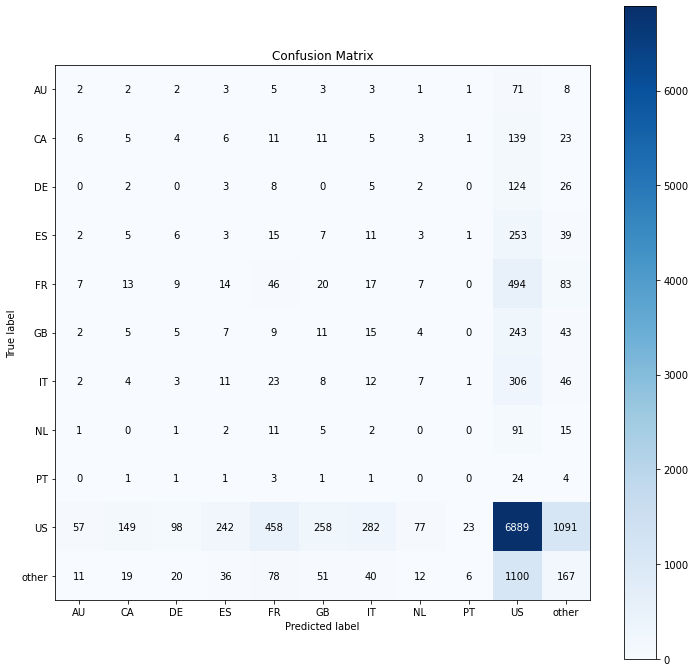

In [40]:
# Accuracy
acc_random = m.accuracy_score( y_test, yhat_random )
print( 'Accuracy: {}'.format( acc_random ) )

# Balanced Accuray
balanced_acc_random = m.balanced_accuracy_score( y_test, yhat_random )
print( 'Balanced Accuracy:{}'.format( balanced_acc_random ) )

# Kappa Metrics
kappa_random = m.cohen_kappa_score( y_test, yhat_random )
print( 'Kappa Score: {}'.format( kappa_random ) )

# Classification report
print( m.classification_report( y_test, yhat_random ) )

# Confusion Matrix
mt.plot_confusion_matrix( y_test, yhat_random, normalize=False, figsize=(12,12))

## 5.2. Neural Network - MLP

In [41]:
ohe = pp.OneHotEncoder()
y_train_nn = ohe.fit_transform( y_train.values.reshape( -1, 1 ) ).toarray()

In [42]:
# model definition
model = ml.Sequential()
model.add( l.Dense( 128, input_dim=x_train.shape[1], activation='relu' ) )
model.add( l.Dense( 11, activation='softmax') )

# model compile
model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )

# train model
model.fit( x_train, y_train_nn, epochs=100 )

Epoch 1/100
1705/1705 [==============================] - 1s 802us/step - loss: 1.4312 - accuracy: 0.6953
Epoch 2/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.2497 - accuracy: 0.7069
Epoch 3/100
1705/1705 [==============================] - 1s 659us/step - loss: 1.2187 - accuracy: 0.7084
Epoch 4/100
1705/1705 [==============================] - 1s 688us/step - loss: 1.1926 - accuracy: 0.7084
Epoch 5/100
1705/1705 [==============================] - 1s 621us/step - loss: 1.1763 - accuracy: 0.7087
Epoch 6/100
1705/1705 [==============================] - 1s 601us/step - loss: 1.1623 - accuracy: 0.7085
Epoch 7/100
1705/1705 [==============================] - 1s 603us/step - loss: 1.1497 - accuracy: 0.7087
Epoch 8/100
1705/1705 [==============================] - 1s 606us/step - loss: 1.1411 - accuracy: 0.7087
Epoch 9/100
1705/1705 [==============================] - 1s 691us/step - loss: 1.1377 - accuracy: 0.7089
Epoch 10/100
1705/1705 [==============================] -

1705/1705 [==============================] - 1s 597us/step - loss: 1.1014 - accuracy: 0.7113
Epoch 79/100
1705/1705 [==============================] - 1s 629us/step - loss: 1.1006 - accuracy: 0.7114
Epoch 80/100
1705/1705 [==============================] - 1s 641us/step - loss: 1.1008 - accuracy: 0.7113
Epoch 81/100
1705/1705 [==============================] - 1s 657us/step - loss: 1.1007 - accuracy: 0.7116
Epoch 82/100
1705/1705 [==============================] - 1s 609us/step - loss: 1.0998 - accuracy: 0.7113
Epoch 83/100
1705/1705 [==============================] - 1s 663us/step - loss: 1.1000 - accuracy: 0.7114
Epoch 84/100
1705/1705 [==============================] - 1s 680us/step - loss: 1.0996 - accuracy: 0.7117
Epoch 85/100
1705/1705 [==============================] - 1s 629us/step - loss: 1.0998 - accuracy: 0.7115
Epoch 86/100
1705/1705 [==============================] - 1s 714us/step - loss: 1.0996 - accuracy: 0.7118
Epoch 87/100
1705/1705 [==============================] - 1

### 5.2.1. NN Performance

In [43]:
# prediction
pred_nn = model.predict( x_test )

# invert prediction
yhat_nn = ohe.inverse_transform( pred_nn )

# prediction prepare
y_test_nn = y_test.to_numpy()
yhat_nn = yhat_nn.reshape( 1, -1 )[0]

Accuracy: 0.7037037037037037
Balanced Accuracy:0.09157657747845774
Kappa Score: 0.0017449085962158994


/Users/meigarom.lopes/.pyenv/versions/3.8.0/envs/airbnbpredictfirstbooking/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          AU       0.00      0.00      0.00       101
          CA       0.00      0.00      0.00       214
          DE       0.33      0.01      0.01       170
          ES       0.00      0.00      0.00       345
          FR       0.12      0.00      0.00       710
          GB       0.00      0.00      0.00       344
          IT       0.00      0.00      0.00       423
          NL       0.00      0.00      0.00       128
          PT       0.00      0.00      0.00        36
          US       0.71      1.00      0.83      9624
       other       0.16      0.00      0.01      1540

    accuracy                           0.70     13635
   macro avg       0.12      0.09      0.08     13635
weighted avg       0.53      0.70      0.58     13635



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

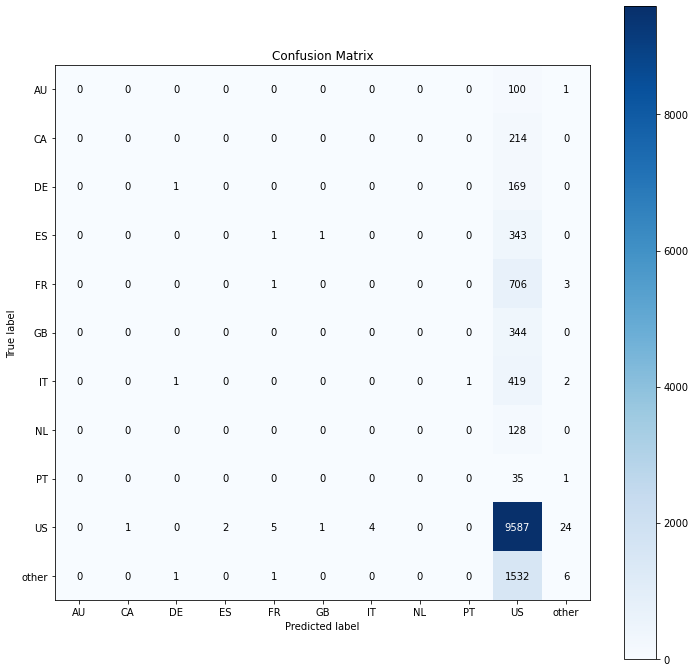

In [44]:
# Accuracy
acc_nn = m.accuracy_score( y_test_nn, yhat_nn )
print( 'Accuracy: {}'.format( acc_nn ) )

# Balanced Accuray
balanced_acc_nn = m.balanced_accuracy_score( y_test_nn, yhat_nn )
print( 'Balanced Accuracy:{}'.format( balanced_acc_nn ) )

# Kappa Metrics
kappa_nn = m.cohen_kappa_score( y_test_nn, yhat_nn )
print( 'Kappa Score: {}'.format( kappa_nn ) )

# Classification report
print( m.classification_report( y_test_nn, yhat_nn ) )

# Confusion Matrix
mt.plot_confusion_matrix( y_test_nn, yhat_nn, normalize=False, figsize=(12,12))

### 5.2.3. NN Performance - Cross-Validation

In [53]:
# generate k-fold
num_folds = 5
kfold = ms.StratifiedKFold( n_splits=num_folds, shuffle=True, random_state=32 )

balanced_acc_list = []
kappa_acc_list = []

i = 1
for train_ix, val_ix in kfold.split( x_train, y_train ):
    print( 'Fold Number: {}/{}'.format( i, num_folds ) )
    
    # get fold
    x_train_fold = x_train.iloc[train_ix]
    y_train_fold = y_train.iloc[train_ix]
    
    x_val_fold = x_train.iloc[val_ix]
    y_val_fold = y_train.iloc[val_ix]
    
    # target hot-encoding
    ohe = pp.OneHotEncoder()
    y_train_fold_nn = ohe.fit_transform( y_train_fold.values.reshape( -1, 1 ) ).toarray()

    # model definition
    model = ml.Sequential()
    model.add( l.Dense( 256, input_dim=x_train.shape[1], activation='relu' ) )
    model.add( l.Dense( 11, activation='softmax') )

    # compile model
    model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )

    # training model
    model.fit( x_train_fold, y_train_fold_nn, epochs=100, batch_size=32, verbose=0 )

    # prediction
    pred_nn = model.predict( x_val_fold )
    yhat_nn = ohe.inverse_transform( pred_nn )
    
    # prepare data
    y_test_nn = y_val_fold.to_numpy()
    yhat_nn = yhat_nn.reshape( 1, -1 )[0]

    # metrics
    ## Balanced Accuracy 
    balanced_acc_nn = m.balanced_accuracy_score( y_test_nn, yhat_nn )
    balanced_acc_list.append( balanced_acc_nn )
    
    ## Kappa Metrics
    kappa_acc_nn = m.cohen_kappa_score( y_test_nn, yhat_nn )
    kappa_acc_list.append( kappa_acc_nn )
    
    i += 1

Fold Number: 1/5
Fold Number: 2/5
Fold Number: 3/5
Fold Number: 4/5
Fold Number: 5/5


In [74]:
print( 'Avg Balanced Accuracy: {} +/- {}'.format( np.round( np.mean( balanced_acc_list ), 2 ), 
                                                  np.round( np.std( balanced_acc_list  ), 4 ) ) )
print( 'Avg Kappa: {} +/- {}'.format( np.round( np.mean( kappa_acc_list ), 4 ), 
                                      np.round( np.std( kappa_acc_list ), 4 ) ) )

Avg Balanced Accuracy: 0.09 +/- 0.0004
Avg Kappa: 0.0021 +/- 0.0017
